<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders on Tabular Data

* Losses
   * https://keras.io/losses/
   * Predefined loss functions: https://github.com/keras-team/keras/blob/master/keras/losses.py
   * Example custom loss function: https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras
   * Loss function that is not f(y_true, y_pred): https://github.com/keras-team/keras/issues/2662
* Having more than one input/output, combined losses: https://keras.io/getting-started/functional-api-guide/
* Normalizaing data: https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize   

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   151k      0 --:--:-- --:--:-- --:--:--  151k


In [0]:
import pandas as pd

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [4]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [5]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [6]:
sns.pairplot?

Object `sns.pairplot` not found.


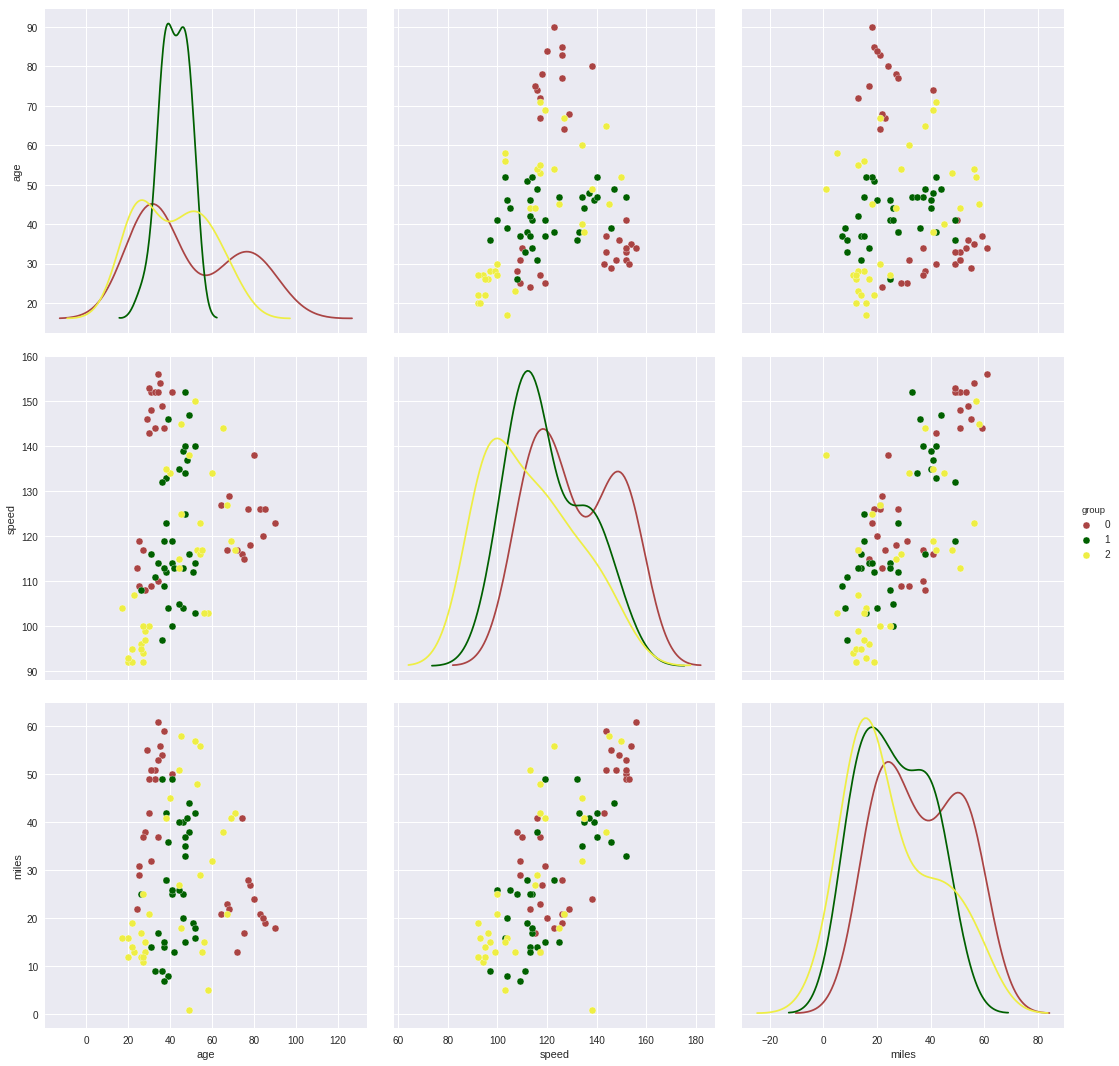

In [7]:
import seaborn as sns

sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, 
             hue="group", palette={0: '#AA4444', 1: '#006000', 2: '#EEEE44'},
#              kind='reg',
             size=5,
             diag_kind='kde',
             vars=['age', 'speed', 'miles'])

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

encoding_dim = 32

input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
encoder (Dense)              (None, 32)                160       
_________________________________________________________________
decoder (Dense)              (None, 4)                 132       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


In [9]:
X = df
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 617.3253
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 17.4311
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1.5692
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3689
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2446
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1450
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0735
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0315
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0143
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0097
CPU times: user 33.2 s, sys: 5.09 s, total: 38.3 s
Wall time: 27.3 s


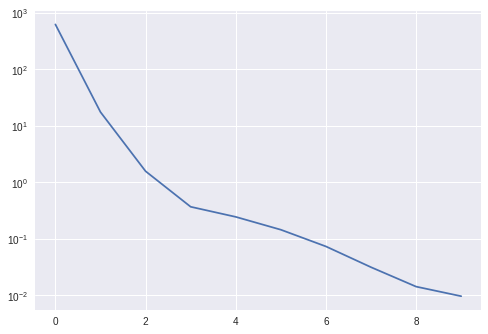

In [10]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [11]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 1s 801us/step


0.010225880570864926

In [12]:
samples = df.sample(10).reset_index(drop=True)
samples

,speed,age,miles,group
0,156.0,34.0,49.0,0
1,134.0,47.0,35.0,1
2,126.0,18.0,21.0,0
3,102.0,50.0,1.0,2
4,130.0,36.0,36.0,0
5,144.0,37.0,59.0,0
6,159.0,43.0,47.0,2
7,136.0,61.0,48.0,2
8,110.0,65.0,28.0,1
9,104.0,39.0,8.0,1


In [13]:
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,155.903458,33.895634,48.946754,-0.014561
1,133.918304,46.951488,34.897083,0.962911
2,126.010933,17.895178,20.810343,-0.059431
3,101.955338,49.992367,0.728906,1.878993
4,129.991150,35.933353,35.905293,-0.002354
5,143.973328,36.925152,59.037369,0.059804
6,158.804062,42.912853,46.940010,1.926477
7,135.878143,60.985699,47.988556,1.993718
8,109.980347,65.021957,27.892563,0.998564
9,104.013329,38.967960,7.767258,0.923815


In [14]:
samples.subtract(predictions)

,speed,age,miles,group
0,0.096542,0.104366,0.053246,0.014561
1,0.081696,0.048512,0.102917,0.037089
2,-0.010933,0.104822,0.189657,0.059431
3,0.044662,0.007633,0.271094,0.121007
4,0.008850,0.066647,0.094707,0.002354
5,0.026672,0.074848,-0.037369,-0.059804
6,0.195938,0.087147,0.059990,0.073523
7,0.121857,0.014301,0.011444,0.006282
8,0.019653,-0.021957,0.107437,0.001436
9,-0.013329,0.032040,0.232742,0.076185


## Looks quite nice, but how impressed are you by abstracting 4 variables into 32?

Let us try dimension of 2

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3776.1423
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2404.6363
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1543.9788
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 979.8786
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 612.2967
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 389.9848
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 274.5585
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 226.6928
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 212.3675
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 209.5242
CPU times: user 33.9 s, sys: 4.74 s, total: 38.7 s
Wall time: 27.6 s


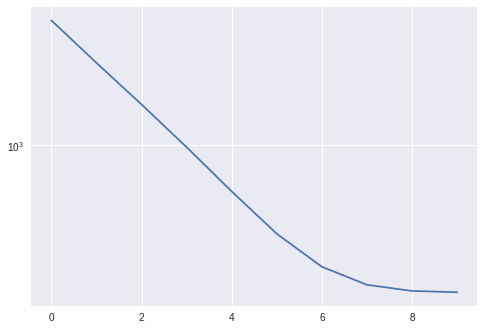

In [15]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice tanh
encoded = Dense(units=encoding_dim, activation='tanh', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# this does not get much better than 210 as a loss (bad), so we can just as well get there a bit faster (10 instead of 50 epochs with standard lr)
adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [16]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 1s 844us/step


209.08789971669515

In [17]:
# just average over all of them :D
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,122.044327,45.207008,30.619259,1.070495
1,122.044327,45.207008,30.619259,1.070495
2,122.044327,45.207008,30.619259,1.070495
3,122.044327,45.207008,30.619259,1.070495
4,122.044327,45.207008,30.619259,1.070495
5,122.044327,45.207008,30.619259,1.070495
6,122.044327,45.207008,30.619259,1.070495
7,122.044327,45.207008,30.619259,1.070495
8,122.044327,45.207008,30.619259,1.070495
9,122.044327,45.207008,30.619259,1.070495


In [18]:
samples.describe()

,speed,age,miles,group
count,10.00000,10.000000,10.0000,10.000000
mean,130.10000,43.000000,33.2000,0.900000
std,20.11329,13.662601,18.8078,0.875595
min,102.00000,18.000000,1.0000,0.000000
25%,114.00000,36.250000,22.7500,0.000000
50%,132.00000,41.000000,35.5000,1.000000
75%,142.00000,49.250000,47.7500,1.750000
max,159.00000,65.000000,59.0000,2.000000


### relu makes it train

Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 5414.4506
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 4505.0444
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 4369.3788
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 4237.4137
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 4108.7555
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3983.1619
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3860.6860
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3741.4332
Epoch 9/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3625.1181
Epoch 10/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3511.9044
CPU times: user 1min 12s, sys: 9.31 s, total: 1min 21s
Wall time: 1min


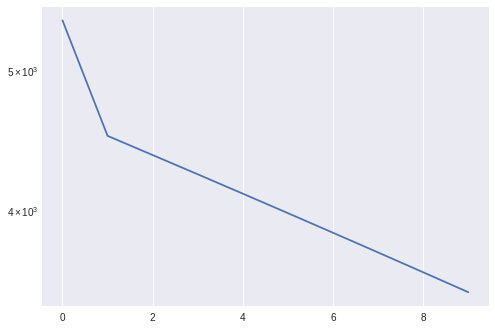

In [19]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [20]:
samples

,speed,age,miles,group
0,156.0,34.0,49.0,0
1,134.0,47.0,35.0,1
2,126.0,18.0,21.0,0
3,102.0,50.0,1.0,2
4,130.0,36.0,36.0,0
5,144.0,37.0,59.0,0
6,159.0,43.0,47.0,2
7,136.0,61.0,48.0,2
8,110.0,65.0,28.0,1
9,104.0,39.0,8.0,1


In [21]:
# all groups close to 1, all off as they might not add to a big error
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,14.599293,13.172466,12.086846,1.002722
1,14.599293,13.172466,12.086846,1.002722
2,14.599293,13.172466,12.086846,1.002722
3,14.599293,13.172466,12.086846,1.002722
4,14.599293,13.172466,12.086846,1.002722
5,14.599293,13.172466,12.086846,1.002722
6,14.599293,13.172466,12.086846,1.002722
7,14.599293,13.172466,12.086846,1.002722
8,14.599293,13.172466,12.086846,1.002722
9,14.599293,13.172466,12.086846,1.002722


### Let's try normalizing the data first (caution: losses do not compare any more)

In [22]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
normalized_df = (df - df.mean()) / df.std()
normalized_df.head()

,speed,age,miles,group
0,-1.391286,-0.057247,-0.356309,0.001632
1,-0.255202,0.526510,-0.421879,0.001632
2,-0.652832,-1.108011,0.233824,-1.222706
3,-1.448090,-1.166386,-1.339863,1.225971
4,-0.482419,-0.407502,-0.553020,0.001632


Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 1.1206
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7024
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5124
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4179
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3667
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3416
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3298
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3232
Epoch 9/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3195
Epoch 10/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3175
CPU times: user 1min 13s, sys: 9.44 s, total: 1min 23s
Wall time: 1min 1s


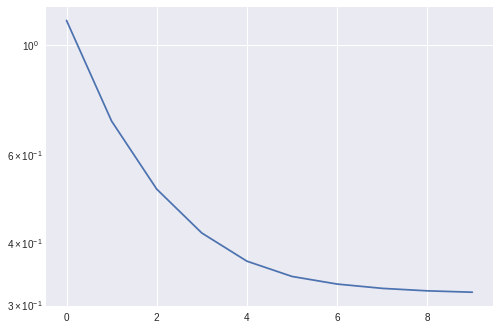

In [23]:
X = normalized_df
encoding_dim = 2

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

## This makes it very hard to estimate how well we did our job, but we can still plot the embedding

Could be interpreted as a fancy version of dimensionality reduction


In [0]:
encoder = Model(inputs=input_data, outputs=encoded)
latent_representation = encoder.predict(X)

In [25]:
latent_representation.shape

(1500, 2)

### Look, ma, clusters

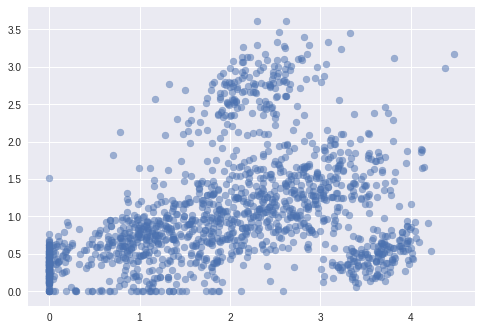

In [26]:
latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]
plt.scatter(latent_x, latent_y, alpha=0.5)

### Clusters have actual meaning

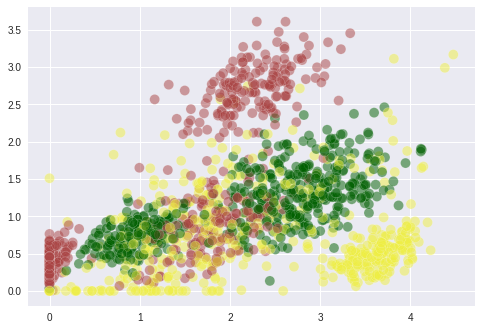

In [27]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

## But color still was not encoded properly: one-hot

In [0]:
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
one_hot_groups = pd.DataFrame(to_categorical(df['group']), columns={'red', 'green', 'yellow'})
main = df.drop('group', axis='columns')

In [29]:
main.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [30]:
one_hot_groups.head()

,red,green,yellow
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


### Challenge: we could feed in both parts in a united way, but they need different loss functions

* write a custom loss function that does this and balances the value: https://keras.io/losses/
* create multi-in/out model that makes this a little bit more transparent: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

In [0]:
# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder")(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder")(group_input)

In [0]:
# latent representation

from tensorflow.keras.layers import concatenate, average, add

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(merged)

In [0]:
# then multi out

main_output = Dense(units=3, activation='linear', name="main_output")(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output")(encoded)

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output])

In [34]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
group_input (InputLayer)        (None, 3)            0                                            
__________________________________________________________________________________________________
main_encoder (Dense)            (None, 2)            8           main_input[0][0]                 
__________________________________________________________________________________________________
group_encoder (Dense)           (None, 2)            8           group_input[0][0]                
__________________________________________________________________________________________________
concatenat

In [0]:
adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mse', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 5000.})

In [36]:
BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': main, 'group_input': one_hot_groups},\
    y={'main_output': main, 'group_output': one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 13s 8ms/step - loss: 54118.0725 - main_output_loss: 391.0879 - group_output_loss: 10.7454
Epoch 2/10
1500/1500 [==============================] - 11s 8ms/step - loss: 53884.7727 - main_output_loss: 157.7882 - group_output_loss: 10.7454
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 53221.7890 - main_output_loss: 259.9370 - group_output_loss: 10.5924
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 3122.3805 - main_output_loss: 2270.2850 - group_output_loss: 0.1704
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 280.8348 - main_output_loss: 274.1120 - group_output_loss: 0.0013
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 276.1069 - main_output_loss: 274.4012 - group_output_loss: 3.4115e-04
Epoch 7/10
1500/1500 [==============================] - 11s 7ms/step - loss: 274.4454 - main_output_loss: 273.7488 - group_outp

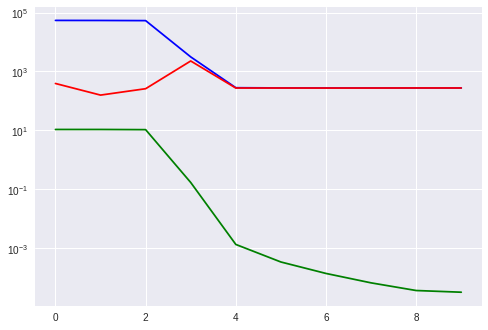

In [37]:
plt.yscale('log')
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

In [0]:
samples = df.sample(10).reset_index(drop=True)
main_samples = samples.drop('group', axis='columns')
group_samples = pd.DataFrame(to_categorical(samples['group']), columns={'red', 'green', 'yellow'})

In [39]:
merged_samples = pd.concat([main_samples, group_samples], axis=1)
merged_samples

,speed,age,miles,red,green,yellow
0,100.0,58.0,55.0,0.0,0.0,1.0
1,126.0,41.0,49.0,0.0,0.0,1.0
2,149.0,35.0,44.0,1.0,0.0,0.0
3,92.0,28.0,21.0,0.0,0.0,1.0
4,126.0,76.0,7.0,1.0,0.0,0.0
5,150.0,34.0,44.0,1.0,0.0,0.0
6,110.0,66.0,52.0,0.0,0.0,1.0
7,152.0,41.0,50.0,1.0,0.0,0.0
8,129.0,68.0,22.0,1.0,0.0,0.0
9,120.0,24.0,16.0,0.0,1.0,0.0


In [40]:
autoencoder.predict([main_samples, group_samples])

[array([[115.240234,  46.453957,  30.679033],
        [115.240234,  46.453957,  30.679033],
        [127.74219 ,  49.154125,  31.337526],
        [115.240234,  46.453957,  30.679033],
        [127.74219 ,  49.154125,  31.337526],
        [127.74219 ,  49.154125,  31.337526],
        [115.240234,  46.453957,  30.679033],
        [127.74219 ,  49.154125,  31.337526],
        [127.74219 ,  49.154125,  31.337526],
        [116.33957 ,  45.852997,  29.53753 ]], dtype=float32),
 array([[2.0286330e-30, 4.7685671e-06, 9.9999523e-01],
        [2.0286330e-30, 4.7685671e-06, 9.9999523e-01],
        [9.9998927e-01, 1.0727247e-05, 2.1348662e-16],
        [2.0286330e-30, 4.7685671e-06, 9.9999523e-01],
        [9.9998927e-01, 1.0727247e-05, 2.1348662e-16],
        [9.9998927e-01, 1.0727247e-05, 2.1348662e-16],
        [2.0286330e-30, 4.7685671e-06, 9.9999523e-01],
        [9.9998927e-01, 1.0727247e-05, 2.1348662e-16],
        [9.9998927e-01, 1.0727247e-05, 2.1348662e-16],
        [7.0477936e-06, 9.99

In [0]:
encoder = Model(inputs=[main_input, group_input], outputs=encoded)
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})

In [42]:
latent_representation.shape

(1500, 2)

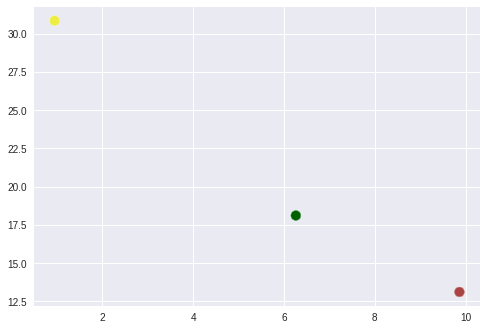

In [43]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### What a funny result: trained to perfectly reproduce the groups, but not much of anything else

quite obviously we ware emphasizing the group loss way too much